In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math
import pandas as pd

## Image Preprocessing

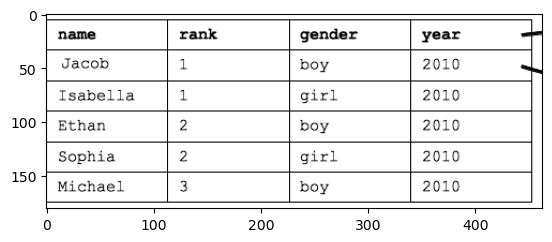

In [2]:
file_path = 'baby_names.png'
img = cv.imread(file_path)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img, cmap = 'gray')

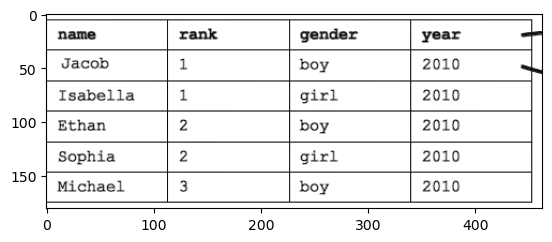

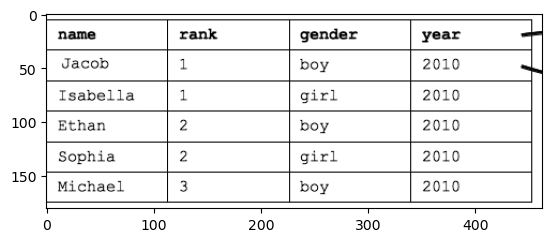

In [3]:
ahe = cv.createCLAHE()
ahe_image = ahe.apply(img)
# _, ahe_image = cv.threshold(ahe_image, 0, 1, cv.THRESH_BINARY + cv.THRESH_OTSU)

plt.imshow(ahe_image, cmap = 'gray')
plt.show()

# Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
clahe = cv.createCLAHE(clipLimit=4.0, tileGridSize=(10, 10))
clahe_image = clahe.apply(img)
# _, clahe_image = cv.threshold(clahe_image, 0, 1, cv.THRESH_BINARY + cv.THRESH_OTSU)

plt.imshow(clahe_image, cmap = 'gray')
plt.show()

### Vertical Line Detection and Segmentation

In [4]:
def detect_v_lines(image, initial_threshold, output):
    if(image.shape[0] < 15) | (image.shape[1] < 15):
        return
    
    lines = None
    thresh = initial_threshold
    
    line_len = 0.95
    while((lines is None) & (line_len > 0.3)):        
        edges = cv.Canny(image, thresh, thresh * 2) # This threshold must also change  
        thresh = initial_threshold
        while((lines is None) & (thresh >= 1)):
            # print(thresh, line_len)
            lines = cv.HoughLinesP(edges, 1, np.pi / 2, thresh, None, edges.shape[0] * line_len, 2)            
            if lines is not None:
                lines = lines.reshape(lines.shape[0], 4) # Reshape from a 3D array to a 2D array
                lines = np.array([line for line in lines if line[0] == line[2]]) # Make sure we are only keeping vertical lines
                if lines.shape[0] == 0:
                    lines = None
            thresh //= 2
        line_len *= 0.95
    
    if lines is not None:
        if len(lines.shape) == 2:
            lines = lines[np.argsort(lines[:, 0])[::-1]] # Sort in descending order by the pixel value of the vertical line
        
        for line in lines:
            detect_v_lines(image[:, line[0] + 1:], thresh * 2, output)
            image = image[:, :line[0]] # Cut off the image from the right section (which was either nothing because it's too small or has been added to output)
        
        if image.shape[1] > 3:
            detect_v_lines(image, thresh * 2, output)
    
    else:
        # Add subimage into final output
        output.append(image)

In [5]:
cols_ahe = []
detect_v_lines(ahe_image, 2 ** 15, cols_ahe)

cols_clahe = []
detect_v_lines(clahe_image, 2 ** 15, cols_clahe)

In [6]:
if len(cols_ahe) >= len(cols_clahe):
    cols = cols_ahe
else:
    cols = cols_clahe
    
num_cols = len(cols)

(181, 110)


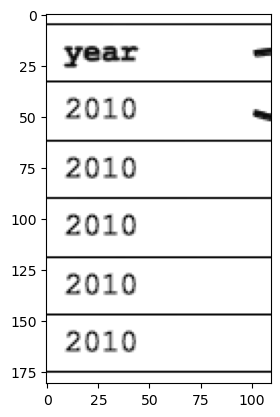

(181, 110)


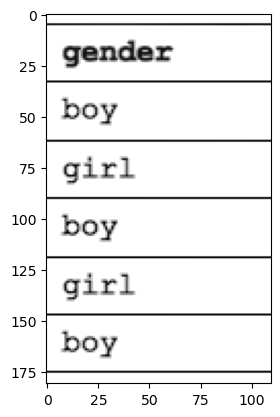

(181, 111)


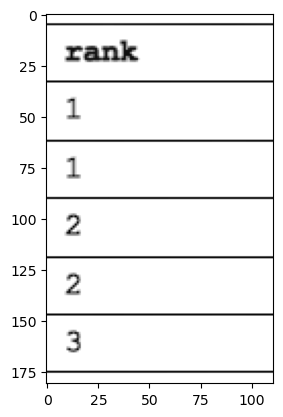

(181, 111)


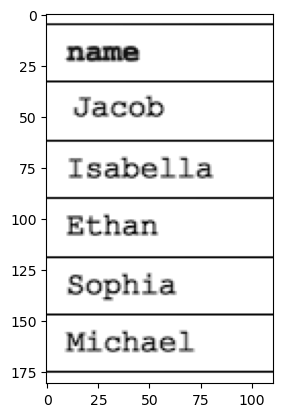

In [7]:
for sub_img in cols:
    print(sub_img.shape)
    plt.imshow(sub_img, cmap = 'gray')
    plt.show()

### Horizontal Line Detection and Segmentation

In [8]:
def detect_h_lines(image, initial_threshold, output):
    if(image.shape[0] <= 5) | (image.shape[1] <= 5):
        return
    
    lines = None
    thresh = initial_threshold
    
    while((lines is None) & (thresh >= 1)):
        edges = cv.Canny(image, thresh, thresh * 2) # This threshold must also change
        lines = cv.HoughLinesP(edges, 1, np.pi / 180, thresh, None, edges.shape[1] - 5, 5)
        if lines is not None:
            lines = lines.reshape(lines.shape[0], 4) # Reshape from a 3D array to a 2D array
            lines = np.array([line for line in lines if line[1] == line[3]]) # Make sure we are only keeping horizontal lines
            if lines.shape[0] == 0:
                lines = None
        thresh //= 2
 
    if lines is not None:
        lines = lines[np.argsort(lines[:, 1])[::-1]] # Sort in descending order by the pixel value of the horizontal line
        for line in lines:
            detect_h_lines(image[line[1] + 1:, ], thresh * 2, output)
            image = image[:line[1], ] # Cut off the image from the bottom section (which was either nothing because it's too small or has been added to output)
            
        if image.shape[0] > 3:
            detect_h_lines(image, thresh * 2, output)
            
    else:
        # Add subimage into final output
        output.append(image)

In [9]:
rows = []

for sub_img in cols:
    boxes = []
    detect_h_lines(sub_img, 2 ** 8, boxes)
    rows.append(boxes)

In [10]:
from statistics import mode

In [11]:
num_rows = []
for row in rows:
    num_rows.append(len(row))

print(num_rows)
num_rows = mode(num_rows)
num_rows

[6, 6, 6, 6]


6

We will find and delete all boxes that are only black or only white.

In [12]:
empty_boxes = []

for i in range(len(rows)):
    for j in range(len(rows[i])):
        if (sum(sum(rows[i][j] != 255)) < 10) | (sum(sum(rows[i][j] != 0)) < 10):
            empty_boxes.append((i, j))

In [13]:
for i, j in reversed(empty_boxes):
    del rows[i][j]

Next we want to determine how many rows will be in our final data frame

In [14]:
num_rows = []
for row in rows:
    num_rows.append(len(row))

print(num_rows)
num_rows = mode(num_rows)
num_rows

[6, 6, 6, 6]


6

## Segmenting By Character and Creation of Final Array of Image

In [15]:
letters = []

num_failed_prev = 1
num_failed_current = 0
letters_prev = []
first_iter = True

for thresh_percent in range(70, 20, -10):
    
    letters_cur = []
    
    for i in range(num_cols):
        for j in range(num_rows):

            # Should break in case of less rows
            if(j >= len(rows[i])):
                break

            image = rows[i][j]
            
            bigger = cv.resize(image, (int(200 * image.shape[1] / image.shape[0]), 200), interpolation = cv.INTER_AREA)

            # Turn image into binary (black background, white letters)
            try:
                _, thresh_binary = cv.threshold(bigger, np.percentile(bigger[bigger < (bigger.max() - 5)], thresh_percent), 255, cv.THRESH_BINARY_INV)
            
                # Records the number of white pixels in each row
                hpp = np.sum(thresh_binary, axis = 1)

                # h_thresh = 255 * thresh_binary.shape[1] / 30 # OLD THAT WORKED FOR OTHER TABLE
                h_thresh = 255 * 10

                # Cut off the top black section
                for k in range(len(hpp)):
                    if(hpp[k] > h_thresh):
                        thresh_binary = thresh_binary[k:, :]
                        break

                hpp = np.sum(thresh_binary, axis = 1)

                # Now cut off the bottom black section
                for k in reversed(range(5, len(hpp))):
                    if(hpp[k] > h_thresh):
                        thresh_binary = thresh_binary[:k, :]
                        break

                # Records the number of white pixels in each column
                vpp = np.sum(thresh_binary, axis = 0)

                box_letters = []
                in_letter = False
                start_idx = 0
                pixel_thresh = thresh_binary.shape[0] / 15 * 255 # ADJUST THIS; originally 12!!

                for k in range(len(vpp)):
                    if(not in_letter) & (vpp[k] > pixel_thresh): # Number of pixels required to start a letter
                        in_letter = True
                        start_idx = k
                    elif (in_letter) & (vpp[k] <= pixel_thresh):
                        in_letter = False
                        # Segment image
                        letter = bigger[:, start_idx:k]

                        # Normalize pixels
                        letter = letter / 255
                        letter = 1 - letter

                        # Resize to 28 x 28 pixels to conform with neural network
                        hpp = np.sum(letter, axis = 1)
                        top_cutoff = 0
                        while (top_cutoff < letter.shape[0]) & (hpp[top_cutoff] == 0):
                            top_cutoff += 1

                        bottom_cutoff = letter.shape[0] - 1
                        while (bottom_cutoff > top_cutoff) & (hpp[bottom_cutoff] == 0):
                            bottom_cutoff -= 1


                        # print(letter.shape)

                        letter = letter[max(0, top_cutoff - 10):min(bottom_cutoff + 10, letter.shape[0]), :]                
                        letter = cv.resize(letter, (max(1, int(letter.shape[1] * 28 / letter.shape[0])), 28), interpolation = cv.INTER_AREA)

                        padding = max(0, (28 - letter.shape[1]) // 2)
                        if (padding != 0) & (((28 - letter.shape[1]) // 2) != ((28 - letter.shape[1]) / 2)):
                            # letter = cv.copyMakeBorder(letter, 0, 0, padding + 1, padding, cv.BORDER_CONSTANT, value=0)
                            letter = cv.copyMakeBorder(letter, 0, 0, padding + 1, padding, cv.BORDER_CONSTANT, value = letter[0, 0])
                        else:
                            # letter = cv.copyMakeBorder(letter, 0, 0, padding, padding, cv.BORDER_CONSTANT, value=0)
                            letter = cv.copyMakeBorder(letter, 0, 0, padding, padding, cv.BORDER_CONSTANT, value = letter[0, 0])

                        # If the image was wider than 28 pixels and you need to resize instead:
                        if letter.shape[1] > 28:
                            num_failed_current += 1
                            # print("Warning: Segmentation likely failed!")
                            # plt.imshow(letter, cmap = 'gray')
                            # plt.show()
                            padded_image = cv.resize(letter, (28, letter.shape[0]), interpolation=cv.INTER_AREA)

                        box_letters.append(letter) # Changed from bigger to thresh_binary

                letters_cur.append(box_letters)

            except:
                continue
                
    print(f"Thresh Percentile: {thresh_percent}")
    print(f"Number of Segmentations Failed: {num_failed_current}")
    if (first_iter & (num_failed_current == 0)) | ((not first_iter) & ((num_failed_current == 0) | (num_failed_prev - num_failed_current <= 0) | (num_failed_current / num_failed_prev < 0.2) | (thresh_percent == 30))):
        if len(letters_prev) != 0:
            letters = letters_prev
        else:
            letters = letters_cur
        break
    else:
        letters_prev = letters_cur
        letters_cur = []
        num_failed_prev = num_failed_current
        num_failed_current = 0
    first_iter = False

Thresh Percentile: 70
Number of Segmentations Failed: 7
Thresh Percentile: 60
Number of Segmentations Failed: 6
Thresh Percentile: 50
Number of Segmentations Failed: 2
Thresh Percentile: 40
Number of Segmentations Failed: 2


In [16]:
for i in range(len(letters)):
    for j in range(len(letters[i])):
        
        letter = letters[i][j] * 255
        
        normalized = cv.normalize(letter, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
        equalized = cv.equalizeHist(normalized)        
        _, thresh = cv.threshold(equalized, 0, 255, cv.THRESH_OTSU + cv.THRESH_BINARY_INV)
        thresh = cv.bitwise_not(thresh)
        threshed = cv.bitwise_and(equalized, equalized, mask=thresh)
        blurred = cv.GaussianBlur(threshed, (3,3), 0)
        
#         print("Threshed Image:")
#         plt.imshow(threshed, cmap = 'gray')
#         plt.show()
        
#         print("Blurred Image:")
#         plt.imshow(blurred, cmap = 'gray')
#         plt.show()
        
        sharpened = cv.addWeighted(threshed, 0.33, blurred, 0.66, 0)
        
#         print("Blurred Image:")
#         plt.imshow(blurred, cmap = 'gray')
#         plt.show()
        
        # print("Weighted Image:")
        # plt.imshow(sharpened, cmap = 'gray')
        # plt.show()
        
        sharpened = sharpened / 255
        letters[i][j] = sharpened

## Pass Through Neural Network

In [17]:
import tensorflow as tf
import keras
from keras.models import load_model

In [18]:
network = load_model("full_ocr.keras")
network.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 11, 11, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1936)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         123,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 93)                  │           6,045 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 405,769 (1.55 MB)

 Trainable params: 135,181 (528.05 KB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 270,364 (1.03 MB)

In [19]:
# The keys of the dictionary are the classification numbers in the df and
# the values are the ASCII codes of the characters
letter_key = dict()
fin = open("letter_key.txt")
for line in fin:
    line = line.strip()
    line = str.split(line, sep = ' ')
    letter_key[line[0]] = line[1]

In [20]:
data_table = np.empty((num_rows * num_cols), dtype = 'object')
i = 0

for box in letters:
    word = []
    for letter in box:
        if letter.shape == (28, 28):
            letter = letter.reshape(-1, 28, 28, 1)
            word.append(chr(int(letter_key[str(np.argmax(network.predict(letter)))])))

    data_table[i] = ''.join(word).lower()
    i += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

## Final Output

In [21]:
data_table = data_table[::-1]
data_table = np.transpose(data_table.reshape(num_cols, num_rows))
data_table = pd.DataFrame(data_table)
data_table

,0,1,2,3
0,b,i,gebabi,8bai
1,jacob,i,b0y,20i0
2,isabeiia,i,g1ti,20i0
3,ethan,2,boy,20i0
4,soph1a,2,g1ti,20i0
5,m1chaei,3,b08,20i0


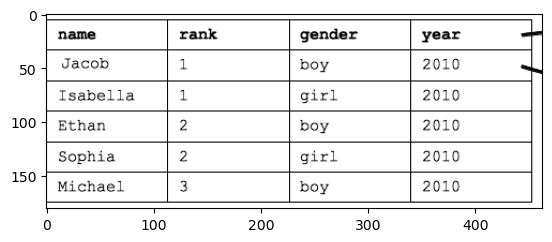

In [22]:
plt.imshow(img, cmap = 'gray')
plt.show()

In [23]:
data_table.to_csv('baby_names.csv', header = True, index = False)